In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns; sns.set()
from google.colab import files
import scipy
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats

In [0]:
# funcs definitions to make significant plot markers 
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)


In [0]:
# read data
audio_type = ['chin','eng']
sub_IDs = ['S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12','S13','S14','S15']

miss = []
fa = []
hit = []
rt_miss = []
rt_fa = []
rt_hit = []

fa_names = []
miss_names = []
hit_names = []
rt_correct = []
rt_incorrect = []

for i in range(len(sub_IDs)):
  miss.append([])
  fa.append([])
  hit.append([])
  rt_miss.append([])
  rt_fa.append([])
  rt_hit.append([])
  rt_correct.append([])
  rt_incorrect.append([])

  for j in range(len(audio_type)):
    if 1: # read from local repo
      url = '../recordings/New_recordings/'
    else: # read from online repo
      url = 'https://raw.githubusercontent.com/neerajww/lang_tcd/venkat201097-test1/code/lisTest/tcdDecision/recordings/New_recordings/'+audio_type[j]+'_'+sub_IDs[i]+'/keys.csv'
    # load csv into a dataframe
    df = pd.read_csv(url,header=None)
    # extract the label (1/2), response (1/2), and session (TRAIN/TEST) columns
    label = df[2].values
    resp = df[3].values
    session = df[4].values
    RT = (df[7].values - df[6].values)*1000 # in msec
    # get index of first TEST stimulus
    session = df[4].values
    for k in range(len(session)):
      if session[k] == 'TEST':
        indx_test = k
        break
    # init HITS and FA 
    miss[i].append(0)
    fa[i].append(0)
    hit[i].append(0)
    # init RTs
    rt_miss[i].append([])
    rt_fa[i].append([])
    rt_hit[i].append([])
    rt_correct[i].append([])
    rt_incorrect[i].append([])
    
    # init indexes
    indx_miss = []
    indx_fa = []
    indx_hit = []
    # compute hits, fa, miss
    for k in range(indx_test,len(label)):
        # MISS
        if int(label[k]) == 2:
          if int(resp[k]) == 1:
            miss[i][j] = miss[i][j]+1
            rt_miss[i][j].append(RT[k])
            indx_miss.append(k)
            
        # FA
        if int(label[k]) == 1:
          if int(resp[k]) == 2:
            fa[i][j] = fa[i][j]+1
            rt_fa[i][j].append(RT[k])
            indx_fa.append(k)
        # HIT
        if int(label[k]) == 2:
          if int(resp[k]) == 2:
            hit[i][j] = hit[i][j]+1
            rt_hit[i][j].append(RT[k])
            indx_hit.append(k)
    
    for k in range(indx_test,len(label)):
      # correct responses
      if int(label[k])==int(resp[k]):
        rt_correct[i][j].append(RT[k])
      else:
        rt_incorrect[i][j].append(RT[k])
         
    # pool the miss and fa files
    temp = df[1].values # get all filenames
    fa_names.extend(temp[indx_fa])
    miss_names.extend(temp[indx_miss])
    hit_names.extend(temp[indx_hit])

# convert to np.array 
miss = np.array(miss)
fa = np.array(fa)
hit = np.array(hit)

In [14]:
# t-test on the miss and fa
twosample_results = scipy.stats.ttest_ind(miss[:,0], miss[:,1])
print(twosample_results.statistic)
print(twosample_results.pvalue)

twosample_results = scipy.stats.ttest_ind(fa[:,0], fa[:,1])
print(twosample_results.statistic)
print(twosample_results.pvalue)



4.53221873785743
0.00011554975641092516
-2.604729426373378
0.015005057623102575


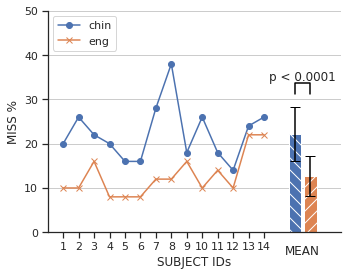

In [91]:
# make MISS plots
NSTIM = 50
sns.set_style("white")
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(5, 4))

ax = plt.subplot(1,1,1)
ax.plot(np.arange(len(sub_IDs)),miss[:,0]/NSTIM*100,'-o',label='chin')
ax.plot(np.arange(len(sub_IDs)),miss[:,1]/NSTIM*100,'-x',label='eng')
ax.set_xlabel('SUBJECT IDs')
ax.set_ylabel('MISS %')
plt.xticks(np.arange(0,14,1),np.arange(1,15,1),rotation=0)
ax.yaxis.grid(True)
ax.legend(loc='upper left')
ax.set_ylim(0,50)
sns.despine()
ax.bar(15,np.mean(miss[:,0]/NSTIM*100),yerr=np.std(miss[:,0]/NSTIM*100), align='center',alpha=1, ecolor='black',capsize=5,hatch="\\\\")
ax.bar(16,np.mean(miss[:,1]/NSTIM*100),yerr=np.std(miss[:,1]/NSTIM*100), align='center',alpha=1, ecolor='black',capsize=5,hatch="//")
ax.text(15.5,-5,'MEAN',horizontalalignment='center')
ax.set_xlim(-1,18)

# Call the function
barplot_annotate_brackets(0, 1, 'p < 0.0001', [15,16],[np.mean(miss[:,0]),np.mean(miss[:,1])], dh=.4)
plt.tight_layout()
# path_store_figs = './/Users/neeks/Desktop/Documents/work/code/matlab_codes/eeg_studies/figures/'
# ax.figure.savefig(path_store_figs+'erp_talkerwise_all.png',dpi=300,format='png')
ax.figure.savefig("human_miss.pdf", bbox_inches='tight')
files.download("human_miss.pdf")
plt.show()

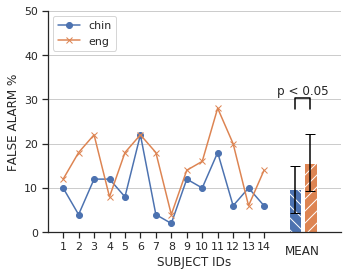

In [92]:
# make FALSE ALARM plots
NSTIM = 50
sns.set_style("white")
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(5, 4))

ax = plt.subplot(1,1,1)
ax.plot(np.arange(len(sub_IDs)),fa[:,0]/NSTIM*100,'-o',label='chin')
ax.plot(np.arange(len(sub_IDs)),fa[:,1]/NSTIM*100,'-x',label='eng')
ax.set_xlabel('SUBJECT IDs')
ax.set_ylabel('FALSE ALARM %')
plt.xticks(np.arange(0,14,1),np.arange(1,15,1),rotation=0)
ax.yaxis.grid(True)
ax.legend(loc='upper left')
ax.set_ylim(0,50)
sns.despine()
ax.bar(15,np.mean(fa[:,0]/NSTIM*100),yerr=np.std(fa[:,0]/NSTIM*100), align='center',alpha=1, ecolor='black',capsize=5,hatch="\\\\")
ax.bar(16,np.mean(fa[:,1]/NSTIM*100),yerr=np.std(fa[:,1]/NSTIM*100), align='center',alpha=1, ecolor='black',capsize=5,hatch="//")
ax.text(15.5,-5,'MEAN',horizontalalignment='center')
ax.set_xlim(-1,18)

# Call the function
barplot_annotate_brackets(0, 1, 'p < 0.05', [15,16],[np.mean(fa[:,0]),np.mean(fa[:,1])], dh=.4)
plt.tight_layout()
plt.show()
path_store_figs = './/Users/neeks/Desktop/Documents/work/code/matlab_codes/eeg_studies/figures/'
# ax.figure.savefig(path_store_figs+'erp_talkerwise_all.png',dpi=300,format='png')
ax.figure.savefig("human_fa.pdf", bbox_inches='tight')
files.download("human_fa.pdf")
plt.show()

In [0]:
# get RT for all correct responses and incorrect responses
y1 = np.array(rt_correct)
y2 = np.array(rt_incorrect)

mu_crt = []
for i in range(y1.shape[1]):
  mu_crt.append([])
  for j in range(y1.shape[0]):
    temp = [k for k in y1[j,i] if k <= 2000]
    mu_crt[i].append(np.mean(temp))
  
mu_icrt = []
for i in range(y1.shape[1]):
  mu_icrt.append([])
  for j in range(y1.shape[0]):
    temp = [k for k in y2[j,i] if k <= 2000]
    mu_icrt[i].append(np.mean(temp))


-2.6276610940180882
0.014232130375021341
-2.5098705690926613
0.018636150517829218


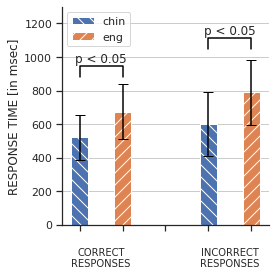

In [95]:
# t-test on correct and incorrect responses
twosample_results = scipy.stats.ttest_ind(mu_crt[0], mu_crt[1])
print(twosample_results.statistic)
print(twosample_results.pvalue)

twosample_results = scipy.stats.ttest_ind(mu_icrt[0], mu_icrt[1])
print(twosample_results.statistic)
print(twosample_results.pvalue)


# make RT plots
sns.set_style("white")
sns.set_style("ticks")

fig, bx = plt.subplots(figsize=(4,4),squeeze=False)


ax = plt.subplot(1, 1, 1)
# ax.bar(np.arange(1,2*len(mu_crt[0]),2),mu_crt[0],width=0.4)
# ax.bar(np.arange(1,2*len(mu_crt[0]),2)+.5,mu_crt[1],width=0.4)
ax.bar([1,4],[np.mean(mu_crt[0]), np.mean(mu_icrt[0])],label='chin',width=0.4,yerr=[np.std(mu_crt[0]),np.std(mu_icrt[0])],align='center',alpha=1, ecolor='black',capsize=5,hatch="\\\\")

# ax = plt.subplot(1, 2, 2)
# ax.bar(np.arange(1,2*len(mu_icrt[1]),2),mu_icrt[0],width=0.4)
# ax.bar(np.arange(1,2*len(mu_icrt[1]),2)+.5,mu_icrt[1],width=0.4)
ax.bar([2,5],[np.mean(mu_crt[1]), np.mean(mu_icrt[1])],label='eng',width=0.4,yerr=[np.std(mu_crt[1]),np.std(mu_icrt[1])],align='center',alpha=1, ecolor='black',capsize=5,hatch="//")
ax.set_xticklabels([])
ax.text(1.5,-250,'CORRECT\nRESPONSES', horizontalalignment='center',fontsize=10)
ax.text(4.5,-250,'INCORRECT\nRESPONSES', horizontalalignment='center',fontsize=10)
ax.yaxis.grid(True)
ax.legend(loc='upper left')
ax.set_ylim(0,1300)
ax.set_ylabel('RESPONSE TIME [in msec]')
sns.despine()
barplot_annotate_brackets(0, 1, 'p < 0.05', [1,2],[np.mean(mu_crt[0]),np.mean(mu_crt[1])], dh=.16)
barplot_annotate_brackets(0, 1, 'p < 0.05', [4,5],[np.mean(mu_icrt[0]),np.mean(mu_icrt[1])], dh=.2)
plt.tight_layout()
plt.show()
ax.figure.savefig("human_response_time.pdf", bbox_inches='tight')
files.download("human_response_time.pdf")




In [0]:
# get the file-wise frequency of miss and fa 
chin_fa_names = []
eng_fa_names = []
chin_miss_names = []
eng_miss_names = []

for i in range(len(fa_names)):
  if 'chinese' in fa_names[i]:
    chin_fa_names.append(fa_names[i])
  if 'english' in fa_names[i]:
    eng_fa_names.append(fa_names[i])
    
for i in range(len(miss_names)):
  if 'chinese' in miss_names[i]:
    chin_miss_names.append(miss_names[i])
  if 'english' in miss_names[i]:
    eng_miss_names.append(miss_names[i])   
    

In [0]:
# make list of files with FA and MISS
fa_names = []
fa_names.append([])
fa_names.append([])

miss_names = []
miss_names.append([])
miss_names.append([])

fa_names_freq = []
fa_names_freq.append([])
fa_names_freq.append([])

miss_names_freq = []
miss_names_freq.append([])
miss_names_freq.append([])

  
fa_names[0] = list(Counter(chin_fa_names).keys())
fa_names[1] = list(Counter(eng_fa_names).keys())
miss_names[0] = list(Counter(chin_miss_names).keys())
miss_names[1] = list(Counter(eng_miss_names).keys())

fa_names_freq[0] = list(Counter(chin_fa_names).values())
fa_names_freq[1] = list(Counter(eng_fa_names).values())
miss_names_freq[0] = list(Counter(chin_miss_names).values())
miss_names_freq[1] = list(Counter(eng_miss_names).values())

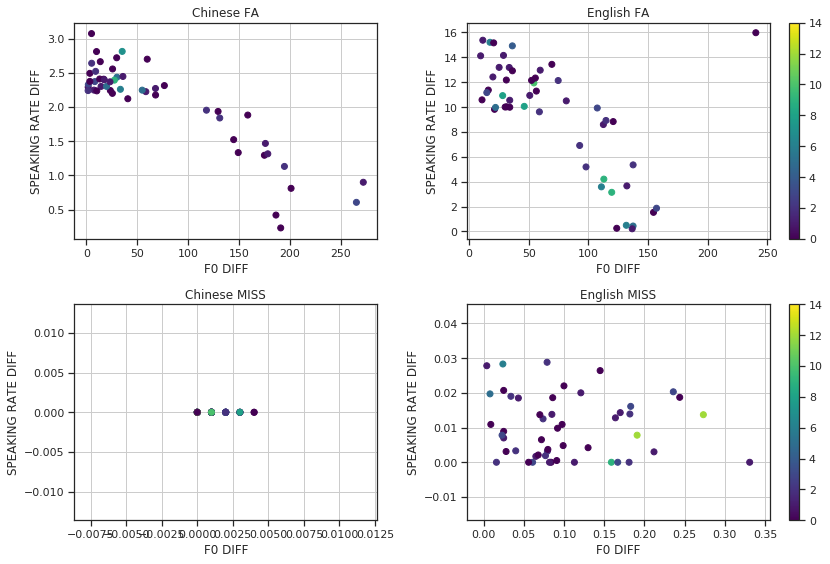

In [6]:
# visualize feature distance and filewise MISS FA count
audio_type = ['chinese','english']
fa_file_details = []
miss_file_details = []

gender = []
spkr_rate = []
f0 = []
nspkrs = []
fa_cnt = []
miss_cnt = []
# make plot
sns.set_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(12,8),squeeze=False)



for i in range(len(audio_type)):
  # load csv into a dataframe
  url = 'https://raw.githubusercontent.com/neerajww/lang_tcd/venkat201097-test1/code/lisTest/tcdDecision/data/stimuli_list/details_stimuli_list_'+audio_type[i]+'.csv'
  df = pd.read_csv(url,header=None)
  file_details = df[0].values
  
  ######
  fa_file_details.append([])
  for j in range(len(fa_names[i])):
    fa_file_details[i].append(df[df[0].str.match(fa_names[i][j].split('/')[-1])].values[0][0])

  ######
  miss_file_details.append([])
  for j in range(len(miss_names[i])):
    miss_file_details[i].append(df[df[0].str.match(miss_names[i][j].split('/')[-1])].values[0][0])
    
  ######
  file_details = df[0].values
  
  spkr_rate.append([])
  f0.append([])
  gender.append([])
  nspkrs.append([])
  fa_cnt.append([])
  miss_cnt.append([])
  for j in range(len(file_details)):
    temp = file_details[j]
    cnt = 0
    for k in range(len(fa_names[i])):
      if temp.split(' ')[0] == fa_names[i][k].split('/')[-1]:
        cnt = fa_names_freq[i][k]
    temp = temp + ' '+str(cnt)
    cnt = 0 
    for k in range(len(miss_names[i])):
      if temp.split(' ')[0] == miss_names[i][k].split('/')[-1]:
        cnt = miss_names_freq[i][k]
    temp = temp + ' '+str(cnt)

  
    nspkrs[i].append(int(file_details[j].split(' ')[0].split('_')[-1].strip('.wav')))
    spkr_rate[i].append(float(temp.split(' ')[2])-float(temp.split(' ')[6]))
    f0[i].append(float(temp.split(' ')[3])-float(temp.split(' ')[7]))
    gender[i].append(temp.split(' ')[4])
    fa_cnt[i].append(float(temp.split(' ')[9]))
    miss_cnt[i].append(float(temp.split(' ')[10]))

  ax = plt.subplot(2, 2,i+1)
  ax.patch.set_facecolor('white')
  indx = [j for j in range(len(nspkrs[i])) if nspkrs[i][j]==1]  
  fig_1 = ax.scatter(np.abs(f0[i])[indx],np.abs(spkr_rate[i])[indx],c=np.abs(fa_cnt[i])[indx],cmap='viridis')
#   indx = [j for j in range(len(nspkrs[i])) if nspkrs[i][j]==2]  
#   fig_1 = ax.scatter(np.abs(f0[i])[indx],np.abs(spkr_rate[i])[indx],c=np.abs(miss_cnt[i])[indx])
  fig.colorbar(fig_1,ax=ax,orientation='vertical')
  fig_1.set_clim(0,14)
  ax.set_xlabel('F0 DIFF')
  ax.set_ylabel('SPEAKING RATE DIFF')
  ax.grid(True)
  ax.set_title(audio_type[i].capitalize() + ' FA')
  plt.tight_layout()


  if i == 0:
    k = 3
  else:
    k =  4 
    
  ax = plt.subplot(2, 2,k)
  ax.patch.set_facecolor('white')
  indx = [j for j in range(len(nspkrs[i])) if nspkrs[i][j]==2]  
  fig_1 = ax.scatter(np.abs(f0[i])[indx],np.abs(spkr_rate[i])[indx],c=np.abs(miss_cnt[i])[indx],cmap='viridis')
  fig.colorbar(fig_1,ax=ax,orientation='vertical')
  fig_1.set_clim(0,14)
  ax.set_xlabel('F0 DIFF')
  ax.set_ylabel('SPEAKING RATE DIFF')
  ax.grid(True)
  ax.set_title(audio_type[i].capitalize() + ' MISS')
  plt.tight_layout()

plt.tight_layout()
plt.show()
ax.figure.savefig("human_response_fa_hit_scatter.pdf", bbox_inches='tight')
files.download("human_response_fa_hit_scatter.pdf")


In [141]:
# regress on the features
audio_type = ['chinese','english']
fa_file_details = []
miss_file_details = []

gender = []
spkr_rate = []
f0 = []
nspkrs = []
fa_cnt = []
miss_cnt = []
# make plot
sns.set_style("white")
sns.set_style("ticks")
# fig, bx = plt.subplots(figsize=(12,4),squeeze=False)

for i in range(len(audio_type)):
  # load csv into a dataframe
  url = 'https://raw.githubusercontent.com/neerajww/lang_tcd/venkat201097-test1/code/lisTest/tcdDecision/data/stimuli_list/details_stimuli_list_'+audio_type[i]+'.csv'
  df = pd.read_csv(url,header=None)
  file_details = df[0].values
  
  ######
  fa_file_details.append([])
  for j in range(len(fa_names[i])):
    fa_file_details[i].append(df[df[0].str.match(fa_names[i][j].split('/')[-1])].values[0][0])

  ######
  miss_file_details.append([])
  for j in range(len(miss_names[i])):
    miss_file_details[i].append(df[df[0].str.match(miss_names[i][j].split('/')[-1])].values[0][0])
    
  ######
  file_details = df[0].values
  
  spkr_rate.append([])
  f0.append([])
  gender.append([])
  nspkrs.append([])
  fa_cnt.append([])
  miss_cnt.append([])
  
  for j in range(len(file_details)):
    temp = file_details[j]
    cnt = 0
    for k in range(len(fa_names[i])):
      if temp.split(' ')[0] == fa_names[i][k].split('/')[-1]:
        cnt = fa_names_freq[i][k]
    temp = temp + ' '+str(cnt)
    cnt = 0 
    for k in range(len(miss_names[i])):
      if temp.split(' ')[0] == miss_names[i][k].split('/')[-1]:
        cnt = miss_names_freq[i][k]
    temp = temp + ' '+str(cnt)

  
    nspkrs[i].append(int(file_details[j].split(' ')[0].split('_')[-1].strip('.wav')))
    spkr_rate[i].append(float(temp.split(' ')[2])-float(temp.split(' ')[6]))
    f0[i].append(float(temp.split(' ')[3])-float(temp.split(' ')[7]))
    gender[i].append(temp.split(' ')[4])
    fa_cnt[i].append(float(temp.split(' ')[9]))
    miss_cnt[i].append(float(temp.split(' ')[10]))


#   indx = [j for j in range(len(nspkrs[i])) if nspkrs[i][j]==1]  
#   regr = linear_model.LinearRegression()
#   regr.fit(np.abs(f0[i])[indx][:, np.newaxis], np.abs(fa_cnt[i])[indx][:, np.newaxis])
#   y_pred = regr.predict(np.abs(f0[i])[indx][:, np.newaxis])
  
#   print('Coefficients: \n', regr.coef_)
#   # The mean squared error
#   print("Mean squared error: %.2f" % mean_squared_error(np.abs(fa_cnt[i])[indx][:, np.newaxis], y_pred))
#   # Explained variance score: 1 is perfect prediction
#   print('Variance score: %.2f' % r2_score(np.abs(fa_cnt[i])[indx][:, np.newaxis], y_pred))
  
#   bx = plt.subplot(1, 2,i+1)
#   bx.plot(np.abs(f0[i])[indx],np.abs(fa_cnt[i])[indx],'o')
#   bx.plot(np.abs(f0[i])[indx],y_pred,'x')  
  
#   indx = [j for j in range(len(nspkrs[i])) if nspkrs[i][j]==1]  
#   regr = linear_model.LinearRegression()
#   regr.fit(np.abs(spkr_rate[i])[indx][:, np.newaxis], np.abs(fa_cnt[i])[indx][:, np.newaxis])
#   y_pred = regr.predict(np.abs(spkr_rate[i])[indx][:, np.newaxis])
  
#   print('Coefficients: \n', regr.coef_)
#   # The mean squared error
#   print("Mean squared error: %.2f" % mean_squared_error(np.abs(fa_cnt[i])[indx][:, np.newaxis], y_pred))
#   # Explained variance score: 1 is perfect prediction
#   print('Variance score: %.2f' % r2_score(np.abs(fa_cnt[i])[indx][:, np.newaxis], y_pred))
  
#   bx = plt.subplot(1, 2,i+1)
#   bx.plot(np.abs(spkr_rate[i])[indx],np.abs(fa_cnt[i])[indx],'o')
#   bx.plot(np.abs(spkr_rate[i])[indx],y_pred,'x')
#   bx.grid(True)
# plt.show()
  if 0:
    indx = [j for j in range(len(nspkrs[i])) if nspkrs[i][j]==1]  
    indx_1 = [j for j in range(len(indx)) if np.abs(fa_cnt[i])[indx][j]>0]
  #   indx_1 = indx
    X = [stats.zscore(np.abs(spkr_rate[i])[indx_1][:, np.newaxis]),stats.zscore(np.abs(f0[i])[indx_1][:, np.newaxis])]
    X = np.squeeze(np.array(X)).T
    model = sm.OLS(np.abs(fa_cnt[i])[indx_1][:, np.newaxis], X).fit()
    predictions = model.predict(X) # make the predictions by the model
    print(model.summary())

  if 1:
    indx = [j for j in range(len(nspkrs[i])) if nspkrs[i][j]==2]  
    indx_1 = [j for j in range(len(indx)) if np.abs(miss_cnt[i])[indx][j]>0]
  #   indx_1 = indx
    X = [stats.zscore(np.abs(spkr_rate[i])[indx_1][:, np.newaxis]),stats.zscore(np.abs(f0[i])[indx_1][:, np.newaxis])]
    X = np.squeeze(np.array(X)).T
    model = sm.OLS(np.abs(miss_cnt[i])[indx_1][:, np.newaxis], X).fit()
    predictions = model.predict(X) # make the predictions by the model
    print(model.summary())


# Print out the statistics


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.163
Model:                            OLS   Adj. R-squared (uncentered):              0.110
Method:                 Least Squares   F-statistic:                              3.110
Date:                Thu, 31 Oct 2019   Prob (F-statistic):                      0.0583
Time:                        04:34:31   Log-Likelihood:                         -87.960
No. Observations:                  34   AIC:                                      179.9
Df Residuals:                      32   BIC:                                      183.0
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [0]:
X = [np.abs(spkr_rate[i])[indx_1][:, np.newaxis],np.abs(f0[i])[indx_1][:, np.newaxis]]



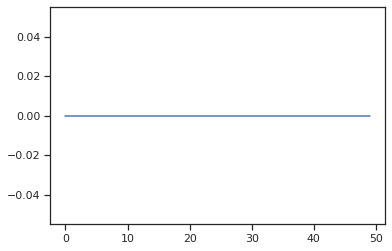

In [140]:
plt.plot(np.abs(miss_cnt[i])[indx])

In [131]:
X.shape

(33, 2)